## Building an ensemble model 
Your task is to explore this synthetic telecom churn dataset to predict behaviour of customers to retain churn. It is a simple dataset that allows you to explore the newly learnt ML skills.
### Churn dataset description 
The dataset contains information about telecommunications customer churn behaviour. It is a fictional telco company that provided mobile phone and internet services and the data is synthetic.   
It contains approximately 4000 records, each representing a customer, and contains a total of 8 variables/ features. These variables cover a variety of aspects related to the customer behaviour, demographic and contract types.


In [9]:
### loading packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.inspection import permutation_importance
# import shap (optional)

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Let's have a function that allows you to print the performance metric for each model 
def get_results(truth, prediction, df, idx):


    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    df.loc[idx,:] = [acc, f1, precision, recall]

    return df


In [11]:
## Read in comma separated file 

df = pd.read_csv('./churn_data.csv',index_col = [0])

In [12]:
import datetime

def clean(df):
    
    # Changing categorical variables value 
    df['contract_type'] = df['contract_type'].str.replace('rolling contract','Rolling Contract')
    df['contract_type'] = df['contract_type'].str.replace('Fixed-contract','Fixed Contract')
    
    # Assuming your DataFrame is called df and the birth date column is 'birth_date'
    df['dob'] = pd.to_datetime(df['dob'], dayfirst = True)
    current_date = datetime.datetime.now()
    df['age'] = (current_date - df['dob']).astype('<m8[Y]')
    
    return df

In [13]:
df = clean(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   prev_month_usage  3813 non-null   float64       
 1   tenure            4000 non-null   float64       
 2   contract_type     4000 non-null   object        
 3   dob               4000 non-null   datetime64[ns]
 4   country           4000 non-null   object        
 5   paperless         4000 non-null   int64         
 6   mob_data          3999 non-null   float64       
 7   churn             4000 non-null   int64         
 8   age               4000 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 312.5+ KB


In [14]:
# First we can check the percentage of missing values in each feature 
print(df.isnull().sum()/len(df)*100)

prev_month_usage    4.675
tenure              0.000
contract_type       0.000
dob                 0.000
country             0.000
paperless           0.000
mob_data            0.025
churn               0.000
age                 0.000
dtype: float64


To be honest, the less than 5% missing value in the column "prev_month_usage" can just be removed as we have a large dataset here. However, for the sake of practicing, let's impute them. 

I will just remove that one missing value in column mob_data

In [15]:
df.dropna(subset=['mob_data'], inplace=True)
print(df.isnull().sum()/len(df)*100)

prev_month_usage    4.676169
tenure              0.000000
contract_type       0.000000
dob                 0.000000
country             0.000000
paperless           0.000000
mob_data            0.000000
churn               0.000000
age                 0.000000
dtype: float64


In [16]:
# extract the target
X = df.drop(columns = ['dob','churn'])
y = df['churn']

In [17]:
# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=456)

In [18]:
## Impute missing values using Simple Imputation method - let's impute our numerical values with 'mean' value and the categorical with 'most_frequent'
### Since we need to impute on both X_train and X_test separately, let's use a function to avoid repeating ourselves!!

def impute_missing_values(df):
    # Separate numerical and categorical features
    num_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    cat_features = df.select_dtypes(include=['object']).columns.tolist()

    # Create separate SimpleImputer instances for numerical and categorical features
    num_imputer = SimpleImputer(strategy='mean')
    cat_imputer = SimpleImputer(strategy='most_frequent')

    # Impute missing values in numerical features
    df_num = df[num_features]
    df_num_imputed = num_imputer.fit_transform(df_num)

    # Convert the imputed numerical features back to a DataFrame
    df_num_imputed_df = pd.DataFrame(df_num_imputed, columns=num_features)

    # Impute missing values in categorical features
    df_cat = df[cat_features]
    df_cat_imputed = cat_imputer.fit_transform(df_cat)

    # Convert the imputed categorical features back to a DataFrame
    df_cat_imputed_df = pd.DataFrame(df_cat_imputed, columns=cat_features)

    # Combine the numerical and categorical DataFrames back into one DataFrame
    df_imputed = pd.concat([df_num_imputed_df, df_cat_imputed_df], axis=1)
    
    return df_imputed

In [19]:
X_train_imputed = impute_missing_values(X_train)
X_test_imputed = impute_missing_values(X_test)

In [21]:
# We can change the parameters in the list to try as we wish; we can try n_estimators in a range of 50-500, max_depth [5,10,20], min_samples_leaf [2,5,10,20]

param_sets = [
    {'n_estimators': 50, 'max_depth': 5,'min_samples_leaf': 2},
    {'n_estimators': 100, 'max_depth': 5,'min_samples_leaf': 2}, 
    {'n_estimators': 250, 'max_depth': 5,'min_samples_leaf': 2},
    # Add more parameter combinations as needed
]

## One-hot encoding on categorical columns before training the model 
X_train_encoded = pd.get_dummies(X_train_imputed, columns=['contract_type','country'], drop_first = True)
X_test_encoded = pd.get_dummies(X_test_imputed, columns=['contract_type','country'], drop_first = True)

for params in param_sets:
    model = RandomForestClassifier(**params, random_state=423)
    model.fit(X_train_encoded, y_train)
    train_pred = model.predict(X_train_encoded)
    y_pred = model.predict(X_test_encoded)
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Parameters: {params}")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Validation Accuracy: {test_accuracy}")

Parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 2}
Training Accuracy: 0.758674585808065
Validation Accuracy: 0.75375
Parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 2}
Training Accuracy: 0.7627383557361676
Validation Accuracy: 0.75625
Parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_leaf': 2}
Training Accuracy: 0.7608627696155048
Validation Accuracy: 0.75875


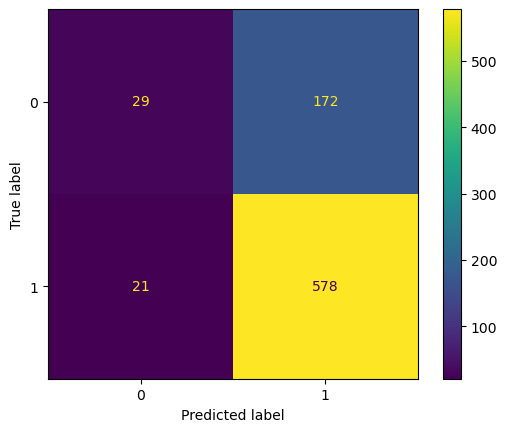

In [22]:
# We will take the model that balance the bias-variance trade-off
rf_model = RandomForestClassifier(n_estimators = 50, max_depth = 5, min_samples_leaf  =2, random_state = 423) 
rf_model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test,y_pred)
 
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot();


In [23]:
## Set up results df

results = pd.DataFrame(index = ['Random Forest', 'Gradient Boost', 'XGBoost'], 
                       columns = ['accuracy', 'f1', 'precision', 'recall'])
# Use our function to get results 
results = get_results(y_test, y_pred, results, 'Random Forest')
results

,accuracy,f1,precision,recall
Random Forest,0.75875,0.856931,0.770667,0.964942
Gradient Boost,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN


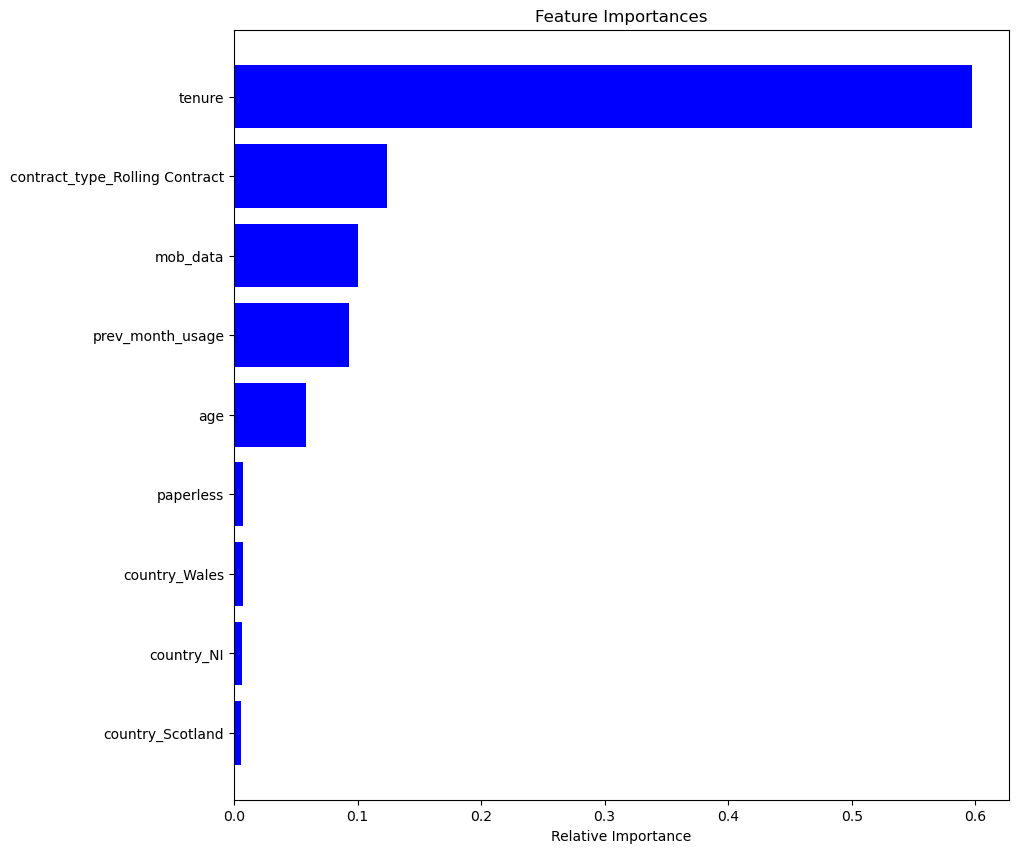

In [25]:
features = X_train_encoded.columns # extract the features name
importances = rf_model.feature_importances_ # extract the feature importance
indices = np.argsort(importances) # sort in descending order

#### Plotting the Variable importance plot

plt.figure(figsize= (10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b',
         align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [32]:
# We can change the parameters in the list to try as we wish; we can try n_estimators in a range of 50-500, max_depth [5,10,20], min_samples_leaf [2,5,10,20]

param_sets = [
    {'n_estimators': 50, 'max_depth': 5,'min_samples_leaf': 20,'learning_rate':0.1},
    {'n_estimators': 50, 'max_depth': 5,'min_samples_leaf': 10,'learning_rate':0.1}, 
    {'n_estimators': 50, 'max_depth': 5,'min_samples_leaf': 5,'learning_rate':0.1},
    # Add more parameter combinations as needed
]


for params in param_sets:
    model = GradientBoostingClassifier(**params, random_state=423)
    model.fit(X_train_encoded, y_train)
    train_pred = model.predict(X_train_encoded)
    y_pred = model.predict(X_test_encoded)
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Parameters: {params}")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Validation Accuracy: {test_accuracy}")

Parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 20, 'learning_rate': 0.1}
Training Accuracy: 0.8080650203188496
Validation Accuracy: 0.74375
Parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 10, 'learning_rate': 0.1}
Training Accuracy: 0.8165051578618319
Validation Accuracy: 0.74625
Parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 5, 'learning_rate': 0.1}
Training Accuracy: 0.8227571115973742
Validation Accuracy: 0.73375


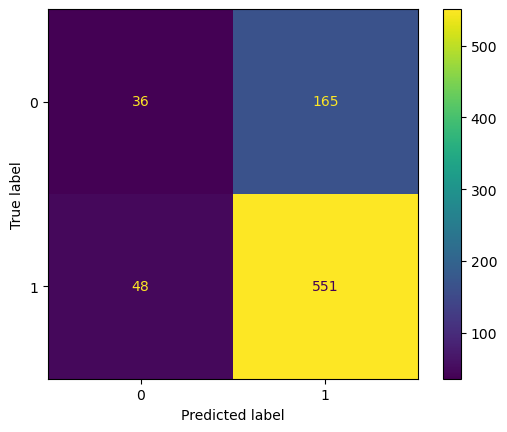

In [33]:
# We will take the model that balance the bias-variance trade-off
gb_model = GradientBoostingClassifier(n_estimators = 50, max_depth = 5, min_samples_leaf  =20, learning_rate = 0.1,random_state = 423) 
gb_model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test,y_pred)
 
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot();

In [35]:
# Use our function to get results 
results = get_results(y_test, y_pred, results, 'Gradient Boost')
results

,accuracy,f1,precision,recall
Random Forest,0.75875,0.856931,0.770667,0.964942
Gradient Boost,0.73375,0.838023,0.769553,0.919866
XGBoost,NaN,NaN,NaN,NaN


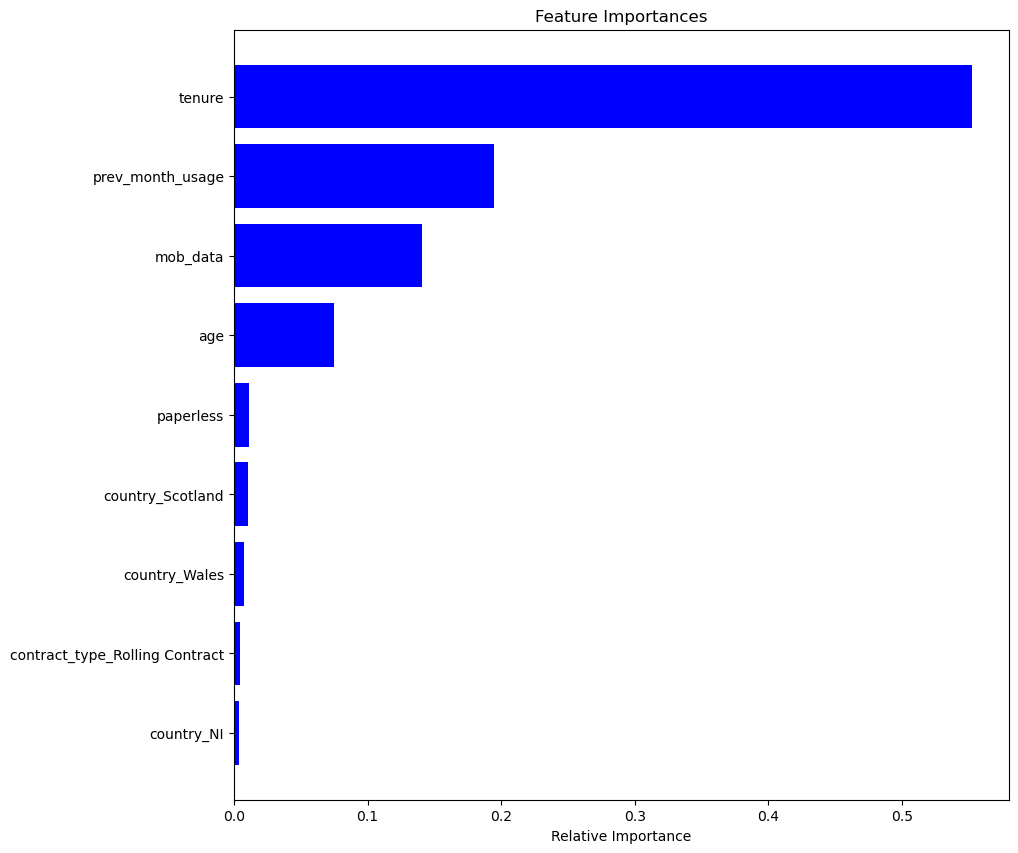

In [38]:
features = X_train_encoded.columns # extract the features name
importances = gb_model.feature_importances_ # extract the feature importance
indices = np.argsort(importances) # sort in descending order


plt.figure(figsize= (10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b',
         align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

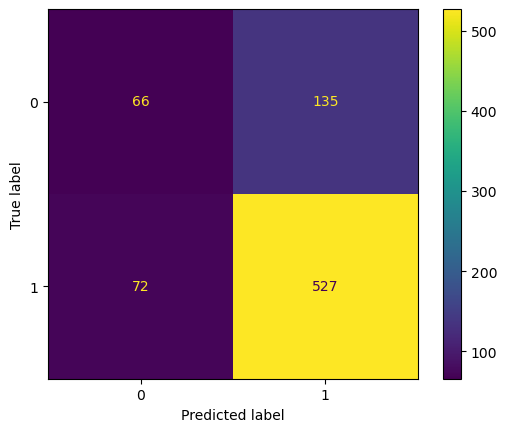

In [39]:
import xgboost as xgb


# Fitting XGBoost to the training data
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_encoded, y_train)
y_pred = xgb_model.predict(X_test_encoded)
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot();


In [40]:
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.74125

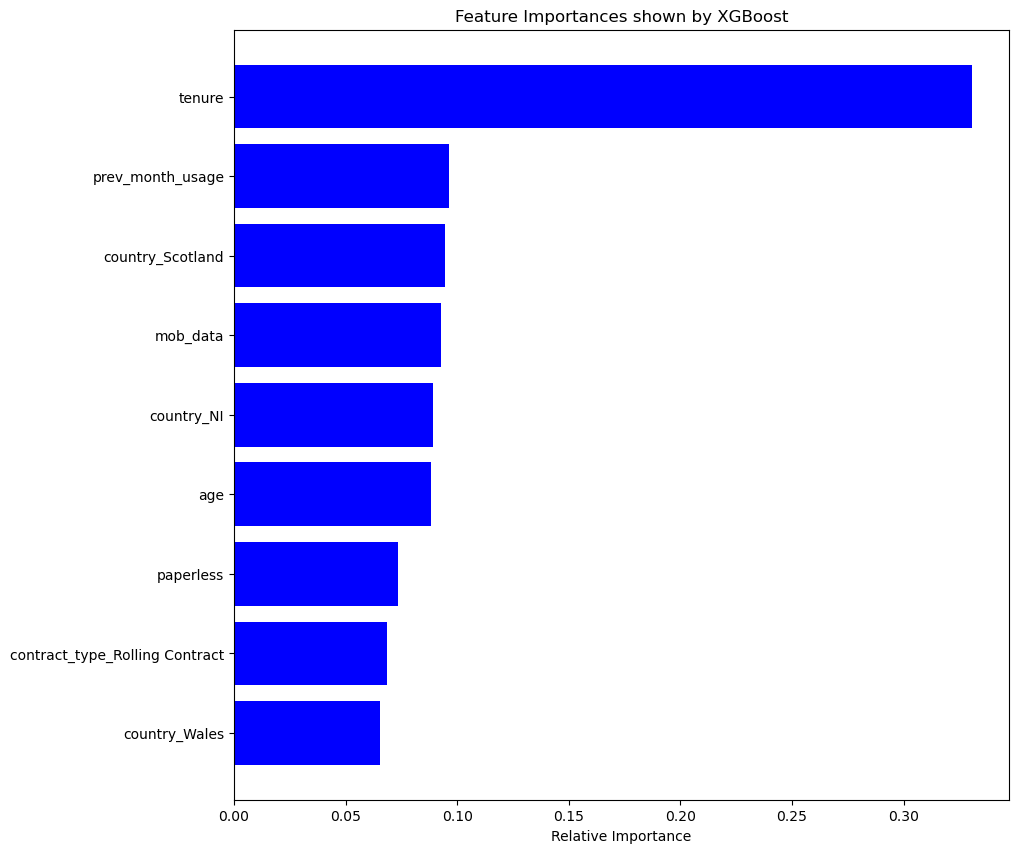

In [42]:
#### Plotting the Variable importance plot
features = X_train_encoded.columns # extract the features name
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize= (10,10))
plt.title('Feature Importances shown by XGBoost')
plt.barh(range(len(indices)), importances[indices], color='b',
         align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [43]:
# Use our function to get results 
results = get_results(y_test, y_pred, results, 'XGBoost')
results

,accuracy,f1,precision,recall
Random Forest,0.75875,0.856931,0.770667,0.964942
Gradient Boost,0.73375,0.838023,0.769553,0.919866
XGBoost,0.74125,0.835845,0.796073,0.8798
